In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
rule = '3T'
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Hour'] = df.index.map(lambda x: x.hour)
df.columns = ['date', 'time', 'open', 'high', 'low','close','volume','hour']
Morning = df[(df['hour'] >= 8) & (df['hour'] <= 13)]
Morning.index += dt.timedelta(minutes=15) # 往前調整15mins
Morning.resample(rule=rule, closed='right', label='right').first()[['open']].iloc[0:3]

rule = '60T'
Morning = df[(df['hour'] >= 8) & (df['hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)
d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]
df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)

Night = df[(df['hour'] < 8) | (df['hour'] > 13)]
d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]
df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()

df_Day = pd.concat([df_Morning, df_Night], axis=0) #先日再夜
df_Day = df_Day.sort_index(ascending=True) #按照時間
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)
trainData = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2018-12-31 00:00:00')].copy()
testData = df_Morning[(df_Morning.index >= '2019-1-1 00:00:00')].copy()
settlementDate_ = pd.read_csv('settlementDate.csv') #, encoding = 'ANSI'
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']] # if第三周->true, else: false
settlementDate = [pd.to_datetime(i).date() for i in list(settlementDate_[bool_]['settlementDate'])] #擷取第三個禮拜的日期資料


In [91]:
df = trainData.copy()
def calculate_macd(df, short_window=10, long_window=53, signal_window=17):
    df['ShortEMA'] = df['close'].ewm(span=short_window, min_periods=1).mean()
    df['LongEMA'] = df['close'].ewm(span=long_window, min_periods=1).mean()
    df['MACD'] = df['ShortEMA'] - df['LongEMA']
    df['SignalLine'] = df['MACD'].ewm(span=signal_window, min_periods=1).mean()
calculate_macd(df)

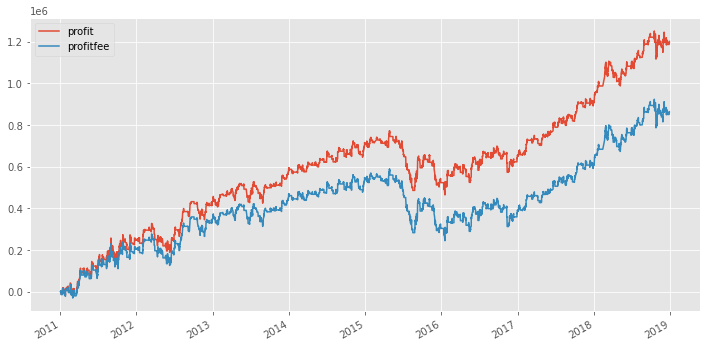

In [92]:
df_arr = np.array(df)
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)
FEE=600
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    entryLong = df_arr[i,8] > df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate
    exitShort = df_arr[i,8] < df_arr[i,9]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-0.05) #比進場價格少了4%
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+0.05) #比進場價格多了4%
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1 #下一期再買
            buy.append(t) #紀錄進場時間
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee);

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6));

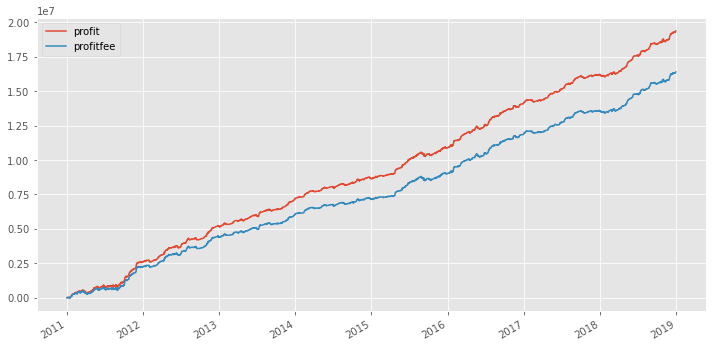

In [108]:
df_arr = np.array(df)
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] 
FEE = 600
BS = None
buy = []
sell = []
short = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
position = 200
count_B = 0
count_S = 0
for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    entryLong = df_arr[i,8] > df_arr[i,9]
    entryShort = df_arr[i,8] < df_arr[i,9] 
    entryCondition = date_arr[i] not in settlementDate
    exitShort = df_arr[i,8] < df_arr[i,9]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-0.05)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+0.05)
    elif BS == 'S':
        stopLoss = df_arr[i,2] >= df_arr[t,0] * (1+0.05) 
        stopProfit = df_arr[i,2] <= df_arr[t,0] * (1-0.05)

    if BS == None:
        position = 200
        count_B = 0
        count_S = 0
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)
        elif entryShort and entryCondition:
            count_B = 0
            BS = 'S'
            t = i+1
            short.append(t)
    elif BS == 'B':
        count_B += 1
        profit = -position * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            count_B = 0
            pl_round = position * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
            position =200
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            if count_B ==3:
                position *= 2
            
            
    elif BS == 'S': 
        count_S += 1
        profit = -position * (df_arr[i,2] - df_arr[i+1,0])
        profit_list.append(profit)
        if entryShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = position * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            buy.append(i+1) 
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            if count_S == 3:
                position *= 2

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6));


In [114]:
import seaborn as sns
import matplotlib.pyplot as py
plt.style.use('ggplot')
print(len(buy))
equity = equity[50:]
equity['equity'] = equity['profitfee']
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy) + len(sell)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

2481
Profit :  16402000.0
Return :  -673.2131147540983
Max DrawDown :  0.5
Caimar Ratio :  -1346.4262295081967
Trade Times :  2646
Win Rate :  0.38492543329302703
Profit Factor :  0.8260905067528946


C:\Users\user\AppData\Local\Temp\ipykernel_1120\3559747206.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equity['equity'] = equity['profitfee']
C:\Users\user\AppData\Local\Temp\ipykernel_1120\3559747206.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
C:\Users\user\AppData\Local\Temp\ipykernel_1120\3559747206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\user\AppData\Local\Temp\ipykernel_1120\235142539.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  year_ret.append(equity[i]['equity'].iloc[-1]/equity[i]['equity'].iloc[0] - 1)


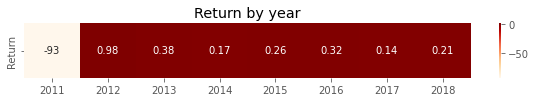

In [116]:
# 時間損益(年)
equity.index = pd.to_datetime(equity.index) #確保索引是datetime型態
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
year_ret = []
for i in years:
    year_ret.append(equity[i]['equity'].iloc[-1]/equity[i]['equity'].iloc[0] - 1)

df = pd.DataFrame({'Return':year_ret},index = years)

# heatmap函式
py.figure(figsize=(10,1))
sns.heatmap(df.transpose(), annot=True, cmap='OrRd')
py.title('Return by year')
py.show()
print('')

In [119]:
import pandas as pd

# 将索引转换为日期时间格式，以便可以按照年份进行筛选
equity.index = pd.to_datetime(equity.index)

# 获取所有2011年的数据
df_2011 = equity[equity.index.year == 2011]

# 删除2011年的数据
equity = equity[equity.index.year != 2011]
equity.head()





,profit,profitfee,equity,drawdown_percent,drawdown
2012-01-02 08:45:00,2595600.0,2240400.0,2240400.0,-0.014169,-32200.0
2012-01-02 09:45:00,2598600.0,2242200.0,2242200.0,-0.013377,-30400.0
2012-01-02 10:45:00,2598600.0,2242200.0,2242200.0,-0.013377,-30400.0
2012-01-02 11:45:00,2600200.0,2242600.0,2242600.0,-0.013201,-30000.0
2012-01-02 12:45:00,2600200.0,2242600.0,2242600.0,-0.013201,-30000.0


2012-01-02 09:45:00    0.000803
2012-01-02 10:45:00    0.000000
2012-01-02 11:45:00    0.000178
2012-01-02 12:45:00    0.000000
2012-01-03 08:45:00    0.007670
2012-01-03 09:45:00    0.000000
2012-01-03 10:45:00    0.001151
2012-01-03 11:45:00    0.000000
2012-01-03 12:45:00    0.000088
2012-01-04 08:45:00    0.000000
2012-01-04 09:45:00    0.001856
2012-01-04 10:45:00    0.000000
2012-01-04 11:45:00    0.000706
2012-01-04 12:45:00    0.000000
2012-01-05 08:45:00    0.002381
2012-01-05 09:45:00    0.000000
2012-01-05 10:45:00    0.000264
2012-01-05 11:45:00   -0.001231
2012-01-05 12:45:00    0.000528
2012-01-06 08:45:00   -0.002816
2012-01-06 09:45:00   -0.001765
2012-01-06 10:45:00    0.006719
2012-01-06 11:45:00   -0.002459
2012-01-06 12:45:00   -0.001408
2012-01-09 08:45:00    0.008286
2012-01-09 09:45:00   -0.002448
2012-01-09 10:45:00    0.000000
2012-01-09 11:45:00    0.000000
2012-01-09 12:45:00    0.000000
2012-01-10 08:45:00    0.005609
2012-01-10 09:45:00    0.000000
2012-01-

                           Strategy
-------------------------  ----------
Start Period               2012-01-02
End Period                 2018-12-28
Risk-Free Rate             0.0%
Time in Market             70.0%

Cumulative Return          632.1%
CAGR﹪                     21.72%

Sharpe                     2.56
Prob. Sharpe Ratio         100.0%
Smart Sharpe               2.51
Sortino                    4.34
Smart Sortino              4.25
Sortino/√2                 3.07
Smart Sortino/√2           3.01
Omega                      2.12

Max Drawdown               -5.84%
Longest DD Days            85
Volatility (ann.)          2.29%
Calmar                     3.72
Skew                       2.9
Kurtosis                   102.73

Expected Daily %           0.02%
Expected Monthly %         2.4%
Expected Yearly %          32.9%
Kelly Criterion            36.66%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.21%
Expected Shortfall (cVaR)  -0.21%

Max Consecutive Wins       37

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2012-01-31,2012-02-04,2012-03-06,36,-5.841778,-5.722558
2,2012-06-11,2012-06-25,2012-07-03,23,-4.477243,-4.452541
3,2012-08-07,2012-09-26,2012-10-23,78,-4.273367,-4.176733
4,2015-08-26,2015-09-14,2015-11-18,85,-3.534299,-3.311845
5,2013-06-26,2013-07-05,2013-07-10,15,-2.664047,-2.561886


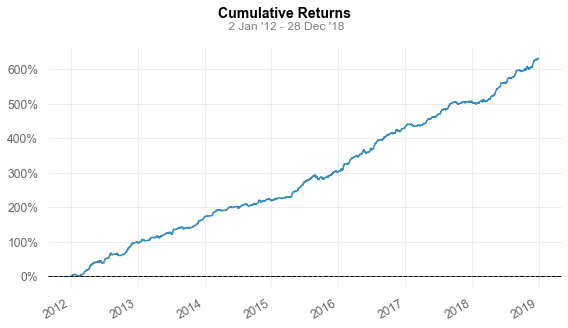

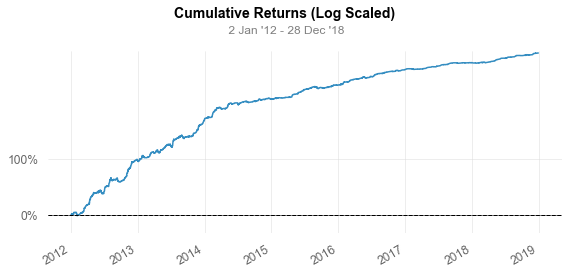

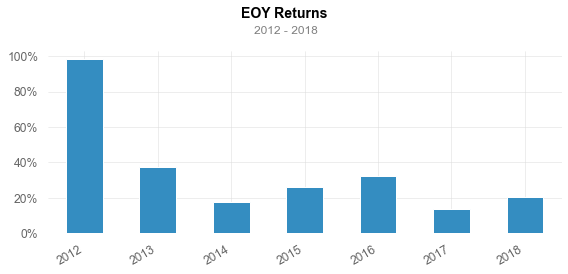

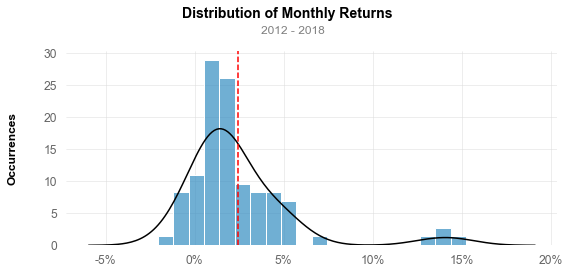

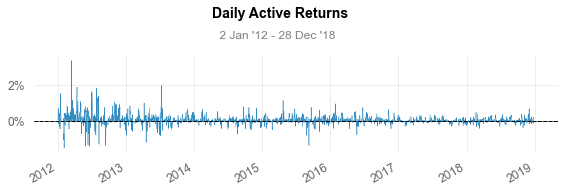

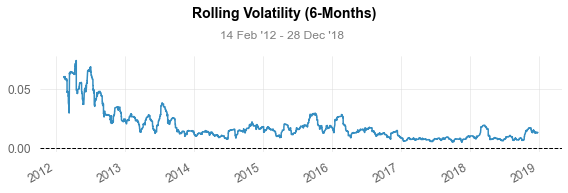

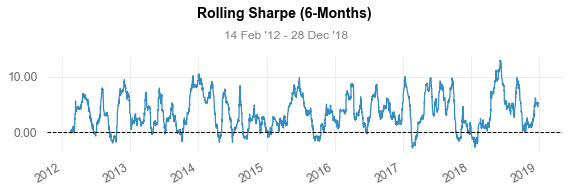

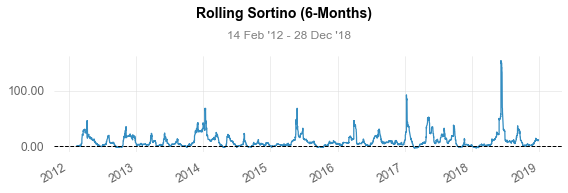

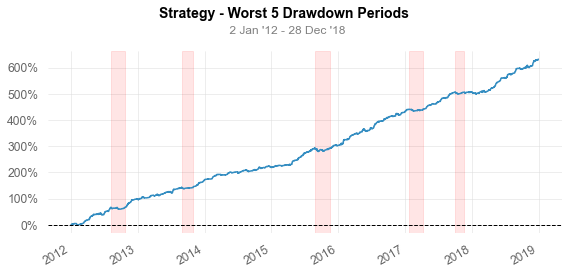

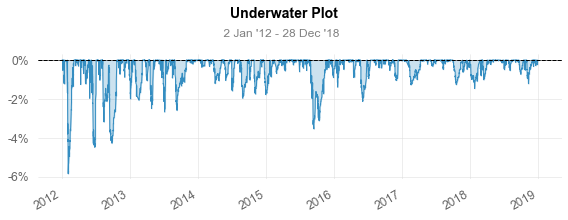

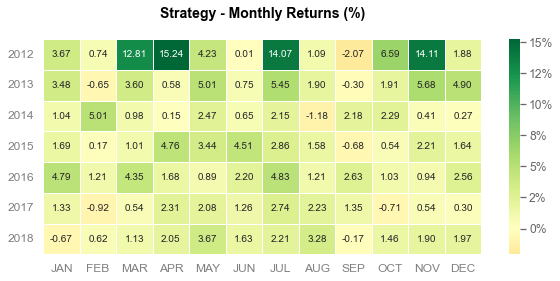

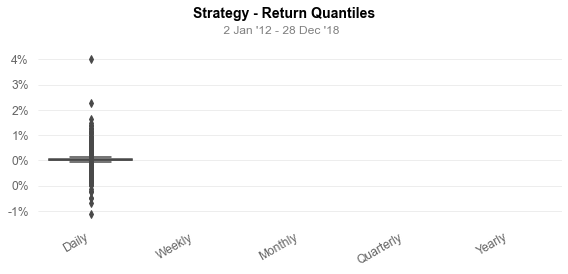

In [120]:
import quantstats
ret = equity['equity'].pct_change(periods=1).dropna()
print(ret)
quantstats.reports.full(ret)
quantstats.reports.html(ret,output='stats.html',title='backtest result',download_filename='result.html')

In [87]:
import random
df = trainData.copy()
def calculate_macd(df, short_window, long_window, signal_window):
    df['ShortEMA'] = df['close'].ewm(span=short_window, min_periods=1).mean()
    df['LongEMA'] = df['close'].ewm(span=long_window, min_periods=1).mean()
    df['MACD'] = df['ShortEMA'] - df['LongEMA']
    df['SignalLine'] = df['MACD'].ewm(span=signal_window, min_periods=1).mean()
    return df

def random_search(df, num_iterations=100):
    best_params = None
    best_profit = float('-inf')
    
    for _ in range(num_iterations):
        short_window = random.randint(5, 20)
        long_window = random.randint(20, 100)
        signal_window = random.randint(5, 30)
        
        df_copy = df.copy()
        df2 = calculate_macd(df_copy, short_window, long_window, signal_window)
        df_arr = np.array(df2)
        time_arr = np.array(df2.index)
        date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)
        FEE=600
        BS = None
        buy = []
        sell = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []
        for i in range(len(time_arr)):
            if i == len(df_arr)-1:
                break
            entryLong = df_arr[i,8] > df_arr[i,9]
            entryCondition = date_arr[i] not in settlementDate
            exitShort = df_arr[i,8] < df_arr[i,9]
            exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
            if BS == 'B':
                stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-0.05) #比進場價格少了4%
                stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+0.05) #比進場價格多了4%
            if BS == None:
                profit_list.append(0)
                profit_fee_list.append(0)
                if entryLong and entryCondition:
                    BS = 'B'
                    t = i+1 #下一期再買
                    buy.append(t) #紀錄進場時間
            elif BS == 'B':
                profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
                profit_list.append(profit)
                if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
                    pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
                    profit_fee = profit - FEE*2
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)
                    BS = None
                    profit_fee_realized = pl_round - FEE*2
                    profit_fee_list_realized.append(profit_fee_realized)
                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee);
        
        equity = 0
        for i in profit_fee_list:
            equity += i
        
        if equity > best_profit:
            best_profit = equity
            best_params = (short_window, long_window, signal_window)
        print(_)
    
    return best_params
best_params = random_search(df, num_iterations=100)

print(best_params)

# equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# equity.plot(grid=True, figsize=(12,6));

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(10, 53, 17)
